In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

### Global Imports

In [2]:
import os
import datetime
import errno
import argparse

import numpy as np
import tensorflow as tf

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Sequential, Model

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

Using TensorFlow backend.


### Training the Model

In [ ]:
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

#direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
#dataset = 'nuclear_movie_hela0-7_same'

direc_data = '/data/npz_data/cells/3T3/NIH/movie/'
dataset = 'nuclear_movie_HeLa_and_3T3'

training_data = np.load('{}{}.npz'.format(direc_data, dataset))

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)
in_shape = (32, 32, 1)
features = {"appearance", "distance", "neighborhood", "regionprop"}

model = siamese_model(input_shape=in_shape, features=features)

tracking_model = train_model_siamese_daughter(model=model,
                                              dataset=dataset,
                                              optimizer=optimizer,
                                              expt='transform_sync',
                                              it=0,
                                              batch_size=128,
                                              min_track_length=6,
                                              features=features,
                                              n_epoch=5,
                                              direc_save='/data/models/cells/3T3/NIH',
                                              direc_data=direc_data,
                                              lr_sched=lr_sched,
                                              rotation_range=180,
                                              flip=True,
                                              shear=0,
                                              class_weight=None)

### Data Review

In [ ]:
data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz')
#data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_HeLa_0_same.npz')
data.keys()
data_readable_X, data_readable_y = data['X'][()], data['y'][()]
print('X Shape:', data_readable_X.shape)
print('y Shape:', data_readable_y.shape)

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

img_raw = data_readable_X[0,0,:,:,0]
img_ann = data_readable_y[0,0,:,:,0]

# Visualize the result 
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_raw, interpolation='none', cmap='gray')
ax[1].imshow(img_ann, interpolation='none', cmap='gray')
ax[0].set_title('Contrast (or Raw) Images')
ax[1].set_title('Annotated Images')
plt.show()

In [ ]:
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

# Compare 2 images
img_1 = train_dict['X'][0,1,:,:,0]
img_2 = train_dict['y'][0,1,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()

### Verifying Model Accuracy with Confusion Matrix

In [ ]:
# Load up data to test
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [ ]:
import deepcell.image_generators as generators

datagen_val = generators.SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0)  # randomly flip images

val_iterator = generators.SiameseIterator(train_dict,
                                          datagen_val,
                                          occupancy_grid_size=10,
                                          crop_dim=32,
                                          min_track_length=5,
                                          features={"appearance", "distance", "neighborhood", "perimeter"})

In [ ]:
from sklearn.metrics import confusion_matrix

Y = []
Y_pred = []
for i in range(1,1001):
    if i % 100 == 0:
        print(".", end="")
    lst, y_true = next(val_iterator)
    y_true = list(map(np.argmax, y_true))
    y_pred = list(map(np.argmax, tracking_model.predict(lst)))
    Y.extend(y_true)
    Y_pred.extend(y_pred)

confusion_matrix(Y, Y_pred)

In [ ]:
sum(np.array(Y) == np.array(Y_pred)) / len(Y)

### Tracking Test

In [ ]:
# Load up data to test
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [7]:
from deepcell.model_zoo import siamese_model

# Import the tracking model
MODEL_DIR = '/data/models/'
PREFIX = 'cells/3T3/NIH/'
in_shape = (32, 32, 1)
features = {"appearance", "neighborhood", "distance", "regionprop"}

# Now we need to re-instantiate the model and load weights
siamese_weights_file = '2018-11-15_nuclear_movie_3T3_and_HeLa_[a,d,n,r]_og=40_epochs=5_seed=777_multicell_0.h5'
siamese_weights_file = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

tracking_model = siamese_model(input_shape=in_shape, neighborhood_scale_size=40, features=features)
tracking_model.load_weights(siamese_weights_file)

In [3]:
test_data = np.load("/data/data/cells/HEK293/generic/set0/deepcell_segmentations_v1/nuclear_movie_HEK293_set0_large.npz")

In [4]:
test_data['X'][0].shape

(71, 1080, 1280, 1)

In [8]:
import importlib
import deepcell.tracking
importlib.reload(deepcell.tracking)

# batch = 10
# trial = deepcell.tracking.cell_tracker(train_dict['X'][batch], train_dict['y'][batch],
trial = deepcell.tracking.cell_tracker(test_data['X'][0], test_data['y'][0],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     neighborhood_scale_size=40,
                     features=features)
trial._track_cells()

Tracking frame 1
cells in frame [1711 1712 1713 1714 1715 1716 1717 1718 1719 1720 1721 1722 1723 1724
 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736 1737 1738
 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751 1752
 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765 1766
 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779 1780
 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792 1793 1794
 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806 1807 1808
 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820 1821 1822
 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834 1835 1836
 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849 1850
 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864
 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878
 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892
 1893 1894 1895 1896 1897 1898 1899 1900 1901

KeyboardInterrupt: 

## Visualizing the Result

In [139]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0):
    fig = plt.figure()    
    ims = []
    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap='cubehelix', vmin=0, vmax=20)
        ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=75, repeat_delay=1000)
#         plt.close()
    return HTML(ani.to_jshtml())

In [ ]:
# print("track ids:", len(trial.tracks))
# trial.tracks[0]['frames']
# The labels are all advanced on

for key, track in trial.tracks.items():
    print(key, track['daughters'], track['frames'])

In [ ]:
for i in range(40):
    print(i, np.unique(trial.y_tracked[i]))
    
# np.sum(trial.y_tracked[29] == 8)

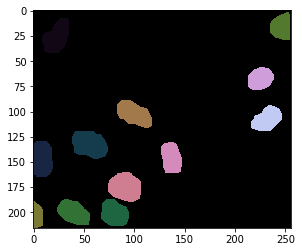

In [225]:
get_js_video(np.expand_dims(trial.y_tracked, axis=0))

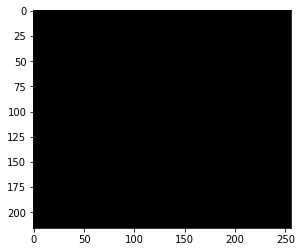

In [192]:
#get_js_video(test_data['y'])
get_js_video(train_dict['y'], batch=batch)
#get_js_video(train_dict['y'], batch=1)

## Save the Raw and Tracked Output

In [ ]:
channel = 0

for i in range(45):
    #name_raw = os.path.join('tracking_movies/test_true2_{:02}_.png'.format(i))
    name_tracked = os.path.join('tracking_movies/test_tracked3_{:02}_.png'.format(i))
    #plt.imsave(name_raw, test_data['y'][0, i, :, :, channel], cmap='jet')
    plt.imsave(name_tracked, trial.y_tracked[i, :, :, channel], cmap='cubehelix', vmin=0, vmax=250)


In [ ]:
print(trial.y_tracked.shape)

In [ ]:
print([key for key in trial.tracks.keys()])
print([trial.tracks[key]['label'] for key in trial.tracks.keys()])
print([trial.tracks[key]['parent'] for key in trial.tracks.keys()])
print([trial.tracks[key]['daughters'] for key in trial.tracks.keys()])
print([trial.tracks[key]['capped'] for key in trial.tracks.keys()])
print(trial.tracks[0]['frames'])
print(trial.tracks[5]['frames'])
print(trial.tracks[6]['frames'])
print(trial.tracks[7]['frames'])

In [ ]:
BASE_DIR = '/data/cells/'
cell_type = 'HeLa/S3'
cell_set = 0
montage

filename = '2018-11-04_nuclear_movie_hela0-7_same_[a,d,n,r]_og=20_epochs=5_normalized_0.h5'
other_filename = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

In [ ]:
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import time

datagen_val = SiameseDataGenerator(
    rotation_range=180,  # randomly rotate images by 0 to rotation_range degrees
    shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
    horizontal_flip=0,  # randomly flip images
    vertical_flip=0)  # randomly flip images

batch_size=128
min_track_length=5
# fit the model on the batches generated by datagen.flow()
test = datagen_val.flow(train_dict, batch_size=batch_size, min_track_length=min_track_length, shuffle=False)

cm = np.zeros((3,3))
N_div = 0.
N_tot = 0.

for batch_x, batch_y in test:
    clear_output(wait=True)
    
    y_pred = tracking_model.predict(batch_x)
    
    truth = np.argmax(batch_y, axis=-1)
    pred = np.argmax(y_pred, axis=-1)
    cm_temp = confusion_matrix(truth,pred)
    if cm_temp.shape[0] == 2:
        cm[0:2,0:2] += cm_temp
    else:
        cm += confusion_matrix(truth,pred)
        
    N_div += np.sum(truth == 2)
    N_tot += truth.shape[0]
    
    print(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2), N_div/N_tot)

    
# y_true = test.classes
# y_pred = tracking_model.predict_generator(test)
# print(y_pred)
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes(x_test)
# print(classification_report(y_true, np.argmax(y_pred, axis=-1)))

## Generating CSV

In [148]:
from deepcell.model_zoo import siamese_model

train_dict, val_dict = get_data('/data/npz_data/cells/3T3/NIH/movie/nuclear_movie_3T3_and_HeLa.npz',
                                mode='siamese_daughters')

# Now we need to re-instantiate the model and load weights
directory = '/data/models/cells/3T3/NIH'
in_shape = (32, 32, 1)
features = {"appearance", "neighborhood", "distance", "regionprop"}
siamese_weights_file = '2018-11-15_nuclear_movie_3T3_and_HeLa_[a,d,n,r]_og=40_epochs=5_seed=777_multicell_0.h5'
siamese_weights_file = os.path.join(directory, siamese_weights_file)
tracking_model = siamese_model(input_shape=in_shape, occupancy_grid_size=40, features=features)
tracking_model.load_weights(siamese_weights_file)

In [223]:
import importlib
import deepcell.tracking
importlib.reload(deepcell.tracking)

batch = 7
trial = deepcell.tracking.cell_tracker(train_dict['X'][batch], train_dict['y'][batch],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     neighborhood_scale_size=40,
                     features=features)
trial._track_cells()

Tracking frame 1
cells in frame [1009 1010 1011 1012 1013 1014 1015 1016 1017]
Tracking frame 2
cells in frame [1018 1019 1020 1021 1022 1023 1024 1025 1026]
Tracking frame 3
cells in frame [1027 1028 1029 1030 1031 1032 1033 1034 1035]
Tracking frame 4
cells in frame [1036 1037 1038 1039 1040 1041 1042 1043 1044]
Tracking frame 5
cells in frame [1045 1046 1047 1048 1049 1050 1051 1052 1053 1054]
New track
Tracking frame 6
cells in frame [1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065]
New track
Division detected
appearances removed from track  4
frames in the track  [0, 1, 2, 3, 4, 5, 6]
length of daughter track  1
daughters  [10]
new track id  11
label  5
frame being removed  6
Tracking frame 7
cells in frame [1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076]
New track
Tracking frame 8
cells in frame [1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087]
Tracking frame 9
cells in frame [1088 1089 1090 1091 1092 1093 1094 1095 1096 1097 1098]
Tracking frame 10
cells in

In [224]:
trial.dataframe()

,label,daughters,frame_div
0,1,[],NaN
1,2,"[14, 15]",28.0
2,3,[],NaN
3,4,[],NaN
4,5,"[11, 12]",6.0
5,6,[],NaN
6,7,[],NaN
7,8,[],NaN
8,9,[],NaN
9,10,[],NaN


In [226]:
import pickle

with open("dumps/track_review_bad_{}.pk".format(batch), "wb") as out:
    pickle.dump(trial.track_review_dict(), out)